In [1]:
# Cell 1: imports + device
import math, time
import numpy as np
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
torch.manual_seed(0); np.random.seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
# Cell 2: data and preprocessing
def make_2gaussian(n_per_class=200, cov_scale=0.3):
    mean1 = np.array([-1.0, -0.5])
    mean2 = np.array([ 1.0,  0.5])
    cov = cov_scale * np.eye(2)
    X1 = np.random.multivariate_normal(mean1, cov, n_per_class)
    X2 = np.random.multivariate_normal(mean2, cov, n_per_class)
    X = np.vstack([X1, X2]).astype(np.float32)
    y = np.vstack([np.zeros((n_per_class,1)), np.ones((n_per_class,1))]).astype(np.float32)
    return X, y

class Preprocessor:
    def __init__(self, whiten=False):
        self.mean = None; self.std = None; self.whiten = whiten; self.pca = None
    def fit(self, X):
        self.mean = X.mean(0)
        Xc = X - self.mean
        self.std = Xc.std(0, ddof=0) + 1e-9
        Xs = Xc / self.std
        if self.whiten:
            self.pca = PCA(whiten=True); self.pca.fit(Xs)
        return self
    def transform(self, X):
        Xc = X - self.mean; Xs = Xc / self.std
        return self.pca.transform(Xs) if self.whiten else Xs

X, y = make_2gaussian(200)
pp = Preprocessor(whiten=False).fit(X)   # toggle whiten=True to decorrelate (PCA/whiten)
Xn = pp.transform(X)


In [3]:
# Cell 3: activation + init helpers
class LeCunTanh(nn.Module):
    def forward(self, x):
        return 1.7159 * torch.tanh((2.0/3.0) * x)

def lecun_uniform_(tensor, fan_in):
    std = 1.0 / math.sqrt(fan_in)
    a = math.sqrt(3.0)*std
    with torch.no_grad():
        tensor.uniform_(-a, a)


In [4]:
# Cell 4: small MLP
class SmallMLP(nn.Module):
    def __init__(self, input_dim=2, hidden=(8,), out_dim=1, activation=LeCunTanh):
        super().__init__()
        dims = [input_dim] + list(hidden) + [out_dim]
        layers = []
        for i in range(len(dims)-1):
            layers.append(nn.Linear(dims[i], dims[i+1], bias=True))
            if i < len(dims)-2:
                layers.append(activation())
        self.net = nn.Sequential(*layers)
        for m in self.net:
            if isinstance(m, nn.Linear):
                lecun_uniform_(m.weight, m.in_features)
                nn.init.constant_(m.bias, 0.0)
    def forward(self, x): return self.net(x)

model = SmallMLP(input_dim=2, hidden=(8,), out_dim=1).to(device)


In [5]:
# Cell 5: training + save weights
def flatten_weights(model):
    return torch.cat([p.detach().cpu().flatten() for p in model.parameters()]).numpy()

def train(model, X, y, lr=1e-2, batch=32, epochs=120, momentum=0.0):
    ds = TensorDataset(torch.from_numpy(X).float(), torch.from_numpy(y).float())
    loader = DataLoader(ds, batch_size=batch, shuffle=True)
    opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    loss_fn = nn.MSELoss()
    history = {'loss': [], 'weights': []}
    for ep in range(epochs):
        epoch_loss = 0.0
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            out = model(xb)
            loss = loss_fn(out, yb)
            loss.backward()
            opt.step()
            epoch_loss += loss.item()*xb.size(0)
        epoch_loss /= len(ds)
        history['loss'].append(epoch_loss)
        history['weights'].append(flatten_weights(model))
    return history

history = train(model, Xn, y, lr=0.02, batch=32, epochs=200, momentum=0.9)


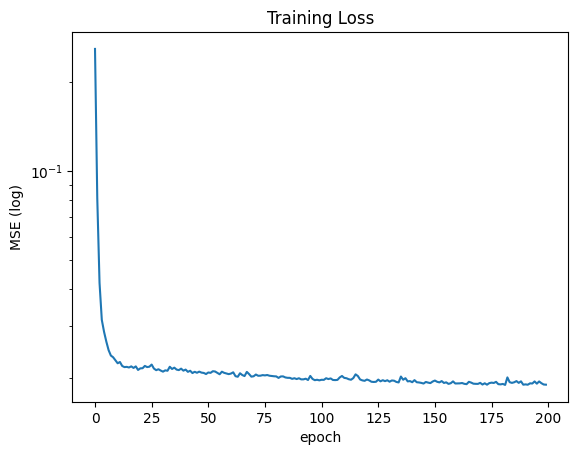

In [6]:
# Cell 6: plot loss
plt.semilogy(history['loss'])
plt.xlabel('epoch'); plt.ylabel('MSE (log)'); plt.title('Training Loss')
plt.show()


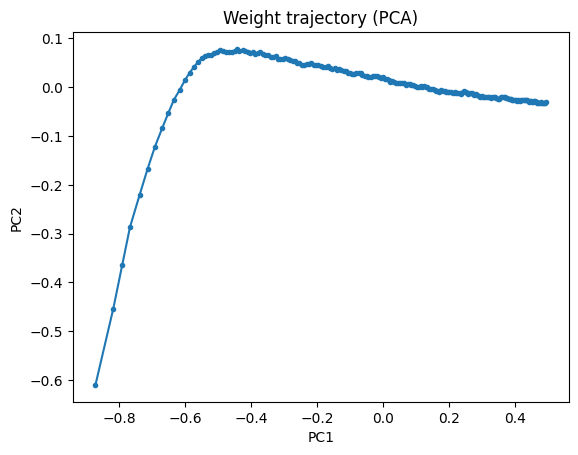

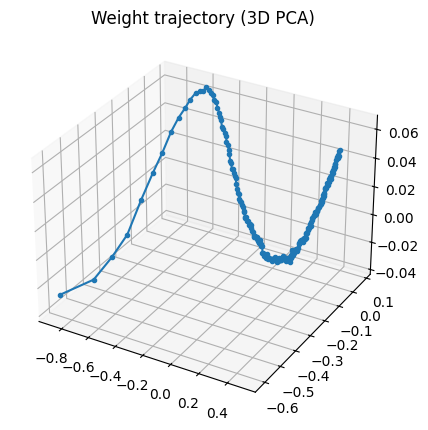

In [7]:
# Cell 7: PCA projection
Ws = np.stack(history['weights'])   # shape (epochs, param_dim)
pca = PCA(n_components=3)
proj = pca.fit_transform(Ws)
# 2D plot
plt.plot(proj[:,0], proj[:,1], '-o', markersize=3)
plt.xlabel('PC1'); plt.ylabel('PC2'); plt.title('Weight trajectory (PCA)')
plt.show()
# 3D plot
fig = plt.figure(figsize=(6,5)); ax = fig.add_subplot(111, projection='3d')
ax.plot(proj[:,0], proj[:,1], proj[:,2], '-o', markersize=3)
ax.set_title('Weight trajectory (3D PCA)'); plt.show()


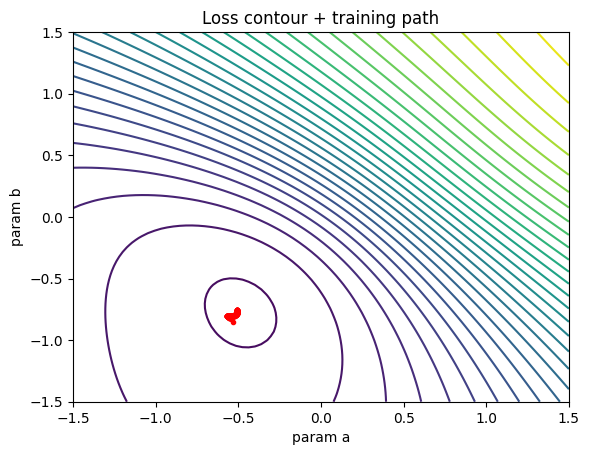

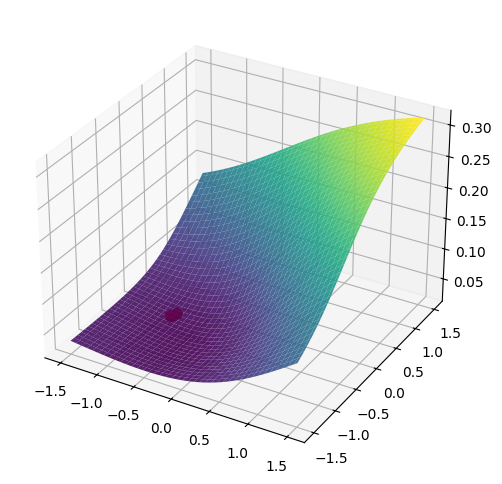

In [8]:
# Cell 8: evaluate loss as function of two parameters
def loss_grid(model, X, y, idx_pair, a_range, b_range, N=60):
    model_cpu = model.to('cpu')
    base = np.concatenate([p.detach().numpy().flatten() for p in model_cpu.parameters()])
    A = np.linspace(a_range[0], a_range[1], N)
    B = np.linspace(b_range[0], b_range[1], N)
    Z = np.zeros((N,N))
    for ia,a in enumerate(A):
        for ib,b in enumerate(B):
            pnew = base.copy()
            pnew[idx_pair[0]] = a; pnew[idx_pair[1]] = b
            # assign back
            with torch.no_grad():
                idx = 0
                for p in model_cpu.parameters():
                    n = p.numel()
                    p.copy_(torch.from_numpy(pnew[idx:idx+n].reshape(p.shape)))
                    idx += n
            out = model_cpu(torch.from_numpy(X).float())
            Z[ib, ia] = ((out - torch.from_numpy(y).float())**2).mean().item()
    # restore original model back to device
    model.to(device)
    return A, B, Z

# choose two parameter indices (pick two coords from flattened vector)
param_dim = len(history['weights'][0])
i0, i1 = 0, 1
A,B,Z = loss_grid(model, Xn, y, (i0,i1), (-1.5,1.5), (-1.5,1.5), N=80)

# overlay trajectory: extract (i0, i1) values across epochs
traj = np.array(history['weights'])[:, [i0,i1]]
# contour
plt.contour(A,B,Z, levels=30)
plt.plot(traj[:,0], traj[:,1], '-o', markersize=3, color='r')
plt.xlabel('param a'); plt.ylabel('param b'); plt.title('Loss contour + training path')
plt.show()
# 3D surface
A2, B2 = np.meshgrid(A,B)
fig = plt.figure(figsize=(8,6)); ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(A2, B2, Z, cmap='viridis', alpha=0.9)
ax.plot(traj[:,0], traj[:,1], [np.interp(ti, A, Z.mean(axis=0)) for ti in traj[:,0]], '-o', color='r')
plt.show()


In [9]:
# Cell 9: H·v via finite differences and power method
def flat_params(model):
    return torch.cat([p.detach().cpu().flatten() for p in model.parameters()]).numpy()

def set_flat_params(model, flat):
    with torch.no_grad():
        idx=0
        for p in model.parameters():
            n = p.numel()
            p.copy_(torch.from_numpy(flat[idx:idx+n].reshape(p.shape)).to(p.device))
            idx += n

def grad_flat(model, X, y, loss_fn=nn.MSELoss()):
    model.zero_grad()
    out = model(torch.from_numpy(X).float().to(device))
    loss = loss_fn(out, torch.from_numpy(y).float().to(device))
    grads = torch.autograd.grad(loss, [p for p in model.parameters() if p.requires_grad], create_graph=False)
    return np.concatenate([g.detach().cpu().flatten().numpy() for g in grads])

def hvp_finite_diff(model, X, y, v, eps=1e-4):
    base = flat_params(model)
    g0 = grad_flat(model, X, y)
    set_flat_params(model, base + eps*v)
    g1 = grad_flat(model, X, y)
    set_flat_params(model, base)  # restore
    return (g1 - g0) / eps

def power_method_topeig(model, X, y, iters=20):
    n = len(flat_params(model))
    v = np.random.randn(n).astype(np.float32); v /= (np.linalg.norm(v)+1e-12)
    for _ in range(iters):
        hv = hvp_finite_diff(model, X, y, v)
        norm = np.linalg.norm(hv) + 1e-12
        v = hv / norm
    return norm, v

eig, vec = power_method_topeig(model, Xn, y, iters=25)
print("Estimated top eigenvalue (H):", eig)


Estimated top eigenvalue (H): 16.356531


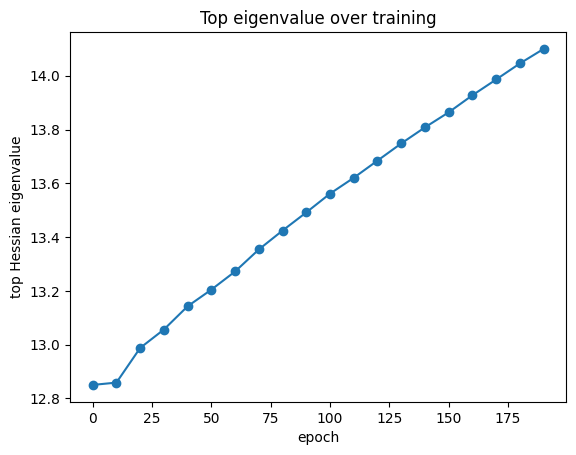

In [10]:
# Cell 10: track top eigenvalue over training (checkpoint every 10 epochs)
eig_history=[]
for t, wflat in enumerate(history['weights']):
    if t % 10 == 0:
        # restore that checkpoint in the model (quick hack: set current model flat)
        set_flat_params(model, wflat)
        eig,_ = power_method_topeig(model, Xn, y, iters=12)
        eig_history.append((t, eig))
times, eigs = zip(*eig_history)
plt.plot(times, eigs, '-o')
plt.xlabel('epoch'); plt.ylabel('top Hessian eigenvalue'); plt.title('Top eigenvalue over training')
plt.show()
